# Student exam performance classification using sklearn Decision tree

In [49]:
#Import libraries:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

## Data preprocessing / cleaning

In [2]:
#Read data into dataframe

df = pd.read_csv('StudentsPerformance.csv')
df.rename(columns={'parental level of education': 'parental education', 'test preparation course': 'prep course'}, inplace=True)
df.head(10)

,gender,race/ethnicity,parental education,lunch,prep course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


In [3]:
print('The dataset consists of ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns.')
missing = df.isnull().sum().sum()
print('Missing (null/NaN) values in dataframe: ' + str(missing))

The dataset consists of 1000 rows, and 8 columns.
Missing (null/NaN) values in dataframe: 0


In the raw dataset, there are three different exam scores included. We want to use an aggregated mean score from these three as an overall performance indicator. The columns are replaced with a new score column, where this is executed: 

In [4]:
#There are several ways to do this. The method that is used here is creation of a new list, and adding it to the end of the DF.

avg_score = []
for row in df.itertuples():
    score = (row._6 + row._7 + row._8) / 3
    score = np.round(score, 3)
    avg_score.append(score)

dn = df
    
dn['score'] = avg_score #Add list as a column in dataframe

# Remove attributes not needed / columns not needed: (could also use df.drop)
del dn['math score']
del dn['reading score']
del dn['writing score']


#Mean score, which will be used for our classification. E.g. above or below average students: 
def mean_value(lst): 
    return sum(lst) / len(lst) 

mean_score = np.round(mean_value(avg_score),3)
print('The mean score for all 1000 students is ' + str(mean_score) + '\n\n')


#our new dataframe:
dn.head(100)

The mean score for all 1000 students is 67.771




,gender,race/ethnicity,parental education,lunch,prep course,score
0,female,group B,bachelor's degree,standard,none,72.667
1,female,group C,some college,standard,completed,82.333
2,female,group B,master's degree,standard,none,92.667
3,male,group A,associate's degree,free/reduced,none,49.333
4,male,group C,some college,standard,none,76.333
...,...,...,...,...,...,...
95,male,group C,associate's degree,free/reduced,completed,80.333
96,male,group B,some high school,standard,completed,64.333
97,female,group E,some college,standard,completed,68.333
98,female,group D,some college,free/reduced,none,62.333


In [5]:
# Statistical data of the clean dataset:
dn.describe()

,score
count,1000.000000
mean,67.770658
std,14.257324
min,9.000000
25%,58.333000
50%,68.333000
75%,77.667000
max,100.000000


In [6]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D0D9D1DB20>]],
      dtype=object)

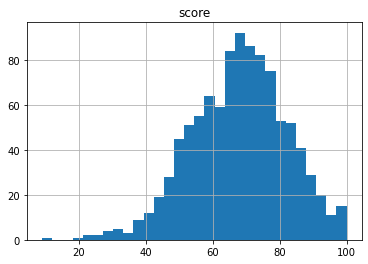

In [7]:
#Present the distribution of scores

#unike = dn['score'].value_counts()
#print(unike)
dn.hist(column='score', bins=30)

#Prøv å bruke seaborn eller annet til å presentere fordelinger av data, bør ha med i rapport også!

### Encoding of categorical variables

As sklearn's decisiontreeclassifier implementation does not handle categorical values, our categorical columns must be one-hot encoded. LabelEncoding might work, but the decision tree will treat the values as continuous numerical. First will try one-hot encoding the categorical values.

- Gender: Male or female (2 categories)

- Race/ethnicity: Groups A, B, C, D, E (5 categories)

- parental education: some high school, high school, some college, associate's degree, bachelor's degree, master's degree (6 categories), this is a ordinal category (eg. low, medium, high) and should be looked into further 

- lunch: standard or free/reduced (2 categories)

- preparation course: none, completed (2 categories)


Variables with two categories will be transformed into 1/0 binary values, to avoid unnecessary high dimensionality. 

The ones that will be one-hot encoded are race/ethnicity and parental education level:

In [8]:
dn.head(100)

,gender,race/ethnicity,parental education,lunch,prep course,score
0,female,group B,bachelor's degree,standard,none,72.667
1,female,group C,some college,standard,completed,82.333
2,female,group B,master's degree,standard,none,92.667
3,male,group A,associate's degree,free/reduced,none,49.333
4,male,group C,some college,standard,none,76.333
...,...,...,...,...,...,...
95,male,group C,associate's degree,free/reduced,completed,80.333
96,male,group B,some high school,standard,completed,64.333
97,female,group E,some college,standard,completed,68.333
98,female,group D,some college,free/reduced,none,62.333


In [9]:
# Pandas approach:
enc_edu = pd.get_dummies(dn['parental education'], prefix = 'parent')
enc_race = pd.get_dummies(dn['race/ethnicity'], prefix = 'race')
enc_gend = pd.get_dummies(dn['gender'], prefix = 'gender')
enc_lunch = pd.get_dummies(dn['lunch'], prefix = 'lunch')
enc_course = pd.get_dummies(dn['prep course'], prefix = 'course')

#For the variables with two categories, we do not want another column as it can just be made binary.
#Concatenate the dummies, and remove the default columns. Furthermore, we remove the extras and rename the 2-dimensioned columns so it is binary

#e.g. gender: 1-female, 0-male,  lunch: 1-standard, 0-free/reduced,  prep course: 1-completed, 0-none
#for the others we will keep all as new variables. 



df2 = pd.concat((dn, enc_edu, enc_race, enc_gend, enc_lunch, enc_course), axis=1)

#drop the original columns, no longer need them,
df2 = df2.drop(['gender', 'race/ethnicity', 'parental education', 'lunch', 'prep course'], axis=1)

#drop the extra variables added due to dummy creation, for the binary variables, and rename
df2 = df2.drop(['gender_male', 'lunch_free/reduced', 'course_none'], axis=1)
df2.rename(columns={'gender_female': 'gender', 'lunch_standard': 'standard lunch', 'course_completed': 'completed course'}, inplace=True)
df2.rename(columns={'race_group A': 'race A', 'race_group B': 'race B', 'race_group C': 'race C', 'race_group D': 'race D', 'race_group E': 'race E'}, inplace=True)

#Thus, we end up with the one-hot encoded dataset: 

df2.head(10)


,score,parent_associate's degree,parent_bachelor's degree,parent_high school,parent_master's degree,parent_some college,parent_some high school,race A,race B,race C,race D,race E,gender,standard lunch,completed course
0,72.667,0,1,0,0,0,0,0,1,0,0,0,1,1,0
1,82.333,0,0,0,0,1,0,0,0,1,0,0,1,1,1
2,92.667,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,49.333,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,76.333,0,0,0,0,1,0,0,0,1,0,0,0,1,0
5,77.333,1,0,0,0,0,0,0,1,0,0,0,1,1,0
6,91.667,0,0,0,0,1,0,0,1,0,0,0,1,1,1
7,40.667,0,0,0,0,1,0,0,1,0,0,0,0,0,0
8,65.000,0,0,1,0,0,0,0,0,0,1,0,0,0,1
9,49.333,0,0,1,0,0,0,0,1,0,0,0,1,0,0


### Target variable encoding

Finally, we need to fix the target column, that is score. Using float values, as they are standing now, makes this a regression type of problem. Our problem proposal was predicting whether a student performs below or above average, based on the input variables. Thus, have to change the score column and classify each score as below or above average:


In [10]:
#Mean is already found to be 67.771, all below are noted below avg and other above avg

mean = 67.771

scoreclass = []
for row in df2.itertuples():
    if(row.score >= mean):
        scoreclass.append('above avg')
    else:
        scoreclass.append('below avg')
    

df2['score'] = scoreclass #Add list as a column in dataframe

enc_target = pd.get_dummies(df2['score'], prefix = 'course')
df2 = pd.concat((df2, enc_target), axis=1)
df2 = df2.drop(['score', 'course_below avg'], axis=1)
df2.rename(columns={'course_above avg': 'above avg score'}, inplace=True)



df2.head(20)


,parent_associate's degree,parent_bachelor's degree,parent_high school,parent_master's degree,parent_some college,parent_some high school,race A,race B,race C,race D,race E,gender,standard lunch,completed course,above avg score
0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1
1,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1
2,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
5,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1
6,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1
7,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
9,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


## Model training

Split the data into train and test data. Target variable is score, while all the others are features/inputs. Start out with a 80-20 split.

In [67]:
feature_cols = ["parent_associate's degree", "parent_bachelor's degree", "parent_high school", "parent_master's degree", "parent_some college", "parent_some high school", "race A", "race B", "race C", "race D", "race E", "gender", "standard lunch", "completed course"]

X = df2[feature_cols] #Features
y = df2['above avg score'] #Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)

classifier = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth=3)

classifier = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))




Accuracy:  0.7


[Text(167.4, 190.26, 'X[12] <= 0.5\ngini = 0.498\nsamples = 950\nvalue = [446, 504]'),
 Text(83.7, 135.9, 'X[13] <= 0.5\ngini = 0.476\nsamples = 338\nvalue = [206, 132]'),
 Text(41.85, 81.53999999999999, 'X[2] <= 0.5\ngini = 0.409\nsamples = 209\nvalue = [149, 60]'),
 Text(20.925, 27.180000000000007, 'gini = 0.427\nsamples = 165\nvalue = [114, 51]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.325\nsamples = 44\nvalue = [35, 9]'),
 Text(125.55000000000001, 81.53999999999999, 'X[5] <= 0.5\ngini = 0.493\nsamples = 129\nvalue = [57, 72]'),
 Text(104.625, 27.180000000000007, 'gini = 0.481\nsamples = 107\nvalue = [43, 64]'),
 Text(146.475, 27.180000000000007, 'gini = 0.463\nsamples = 22\nvalue = [14, 8]'),
 Text(251.10000000000002, 135.9, 'X[13] <= 0.5\ngini = 0.477\nsamples = 612\nvalue = [240, 372]'),
 Text(209.25, 81.53999999999999, 'X[6] <= 0.5\ngini = 0.497\nsamples = 397\nvalue = [183, 214]'),
 Text(188.32500000000002, 27.180000000000007, 'gini = 0.492\nsamples = 368\nvalu

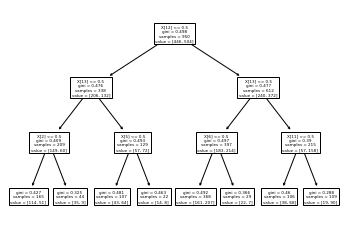

In [68]:
#Visualization

tree.plot_tree(classifier)



## Evaluation